Below is a simple implemenation of Appolo.io API, which allows users to scrape contacts, companies, people, etc. from the Apollo.io website. While it's still a WIP, it does work with basic functionality. Currently, the main drawback is that it only retireives "guessed" emails and seems to activly avoid retrieving "verified" emails. This will be explored in a later version.

In [7]:
# @title Imports the required libraries [run this cell first---you only need to run this cell once]
import requests
import pandas as pd
import numpy as np
import os
from google.colab import drive

In [8]:
# @title MAIN CELL [returns CSV File Mounted to Drive] RUN THIS

"""Mount Google Drive"""
drive.mount('/content/drive')

"""Define the CSV file path in the shared folder "VDC Engineering Contacts List" within My Drive"""
csv_file_path = "/content/drive/My Drive/VDC Engineering Contacts List/Test Engineer Contact List V1.csv"

"""Define the URL and API key"""
url = "https://api.apollo.io/v1/mixed_people/search"
mixed_people_search_api_key = 'ZuGNQ0UXawpNRxU_jxsbYQ'  # Your API key

"""JUST RUN CELL FIRST and then it'll prompt you to enter in the link you have copied (previous version you had to manually change the static code below where domain was equal to the link)"""
""" Get user input for domains or use predefined domains"""
domain_input = input("Enter the domains separated by commas (or leave blank for default): ")

if domain_input:
    # Split input by commas and remove any extra whitespace
    domains = [domain.strip() for domain in domain_input.split(",")]
else:
    # Default domains if no input is provided
    domains = ["http://www.vdcresearch.com/"]  # You can modify this default list/value, but it has no real affect on what is printed

"""Define titles to search for"""
titles = ["software engineer", "system architect", "software engineer in test",
          "mechanical engineer", "product manager", "qa engineer", "software qa engineer", "electrical engineer"] #Ex. if you want you can add or delete titles---like, "strategic planner" or "quality assurance engineer"

headers = {
    'Cache-Control': 'no-cache',
    'Content-Type': 'application/json',
    'X-Api-Key': mixed_people_search_api_key
}

"""Number of pages to fetch"""
num_pages = 7 #Feel free to change this to however many---the number is, from what I can tell so far, rather arbitrary

"""Load the existing CSV file (if it exists) to avoid duplicates and update missing data"""
if os.path.isfile(csv_file_path):
    existing_df = pd.read_csv(csv_file_path)
    existing_contacts = existing_df[['Email']].drop_duplicates().set_index('Email')  # Set index to email for fast lookup
else:
    existing_df = pd.DataFrame()
    existing_contacts = pd.DataFrame()  # Empty if no CSV exists

data_list = []

for domain in domains:
    data = {
        "q_organization_domains": domain,
        "per_page": 100,
        "organization_num_employees_ranges": ["1,1000000"],
        "person_titles": titles,
    }

    for page in range(1, num_pages + 1):
        data["page"] = page
        response = requests.post(url, headers=headers, json=data)

        if response.status_code == 200:
            result = response.json()
            people = result.get('people', [])

            if not people:
                print(f"No more results on page {page} for domain {domain}.")
                break

            for person in people:
                email = person.get('email')
                if email and email != "email_not_unlocked@domain.com":
                    title = person.get('title')
                    first_name = person.get('first_name', '')
                    last_name = person.get('last_name', '')
                    company = person.get('organization', {}).get('name', '')

                    if email not in existing_contacts.index:
                        # New contact, add it
                        data_list.append({
                            'Title': title,
                            'Email': email,
                            'Domain': domain,
                            'Company': company,
                            'First Name': first_name,
                            'Last Name': last_name
                        })
                    else:
                        # If contact exists but has missing data, update it
                        existing_contact = existing_df[existing_df['Email'] == email].iloc[0]

                        # Check for missing fields and update them
                        if pd.isna(existing_contact['Company']) or existing_contact['Company'] == '':
                            existing_df.loc[existing_df['Email'] == email, 'Company'] = company
                        if pd.isna(existing_contact['First Name']) or existing_contact['First Name'] == '':
                            existing_df.loc[existing_df['Email'] == email, 'First Name'] = first_name
                        if pd.isna(existing_contact['Last Name']) or existing_contact['Last Name'] == '':
                            existing_df.loc[existing_df['Email'] == email, 'Last Name'] = last_name

        else:
            print(f"Error on page {page} for domain {domain}: {response.status_code}, {response.text}")
            break

"""Creates a DataFrame from the new data"""
new_df = pd.DataFrame(data_list)

"""Appends new data and update missing values for existing contacts"""
if not new_df.empty:
    combined_df = pd.concat([existing_df, new_df], ignore_index=True)

    """Sorts by 'Domain' and save the updated CSV"""
    combined_df.sort_values(by='Domain', ascending=True, inplace=True)
    combined_df.to_csv(csv_file_path, index=False)
    print("CSV updated with new and updated contacts.")
else:
    """Save any updated information in existing_df back to CSV"""
    existing_df.to_csv(csv_file_path, index=False)
    print("No new contacts found. Existing data updated where necessary.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter the domains separated by commas (or leave blank for default): http://www.takeda.com/
No more results on page 4 for domain http://www.takeda.com/.
CSV updated with new and updated contacts.


In [10]:
# @title If the file/csv exists, the dataframe will be displayed below...

"""Checks to see if the CSV exists. If it does, it'll read and then display it into a dataframe,
and if it doesn't it'll simply display that it doesn't exist."""

# Define the CSV file path in the shared folder
#                                   This portion below may need to be changed if shared, so that it fits the users/creators file and folder names
csv_file = "/content/drive/My Drive/VDC Engineering Contacts List/Test Engineer Contact List V1.csv"

"""Checks if the CSV file exists and read it into a DataFrame"""
if os.path.isfile(csv_file):
    df = pd.read_csv(csv_file)
    print("Columns in DataFrame:", df.columns)
    display(df)

    if 'Domain' in df.columns:
        unique_domains = sorted(df['Domain'].unique())
        print("\nUnique domains already used (in alphabetical order):")
        for domain in unique_domains:
            print(domain)
    else:
        print("The 'Domain' column is not in the DataFrame.")
else:
    print(f"File does not exist: {csv_file}")


Columns in DataFrame: Index(['Title', 'Email', 'Domain', 'Company', 'First Name', 'Last Name'], dtype='object')


,Title,Email,Domain,Company,First Name,Last Name
0,Software Engineer,j.leono@varengold.de,Here are the links separated by commas: http:...,Rakuten,Josses,Leono
1,Software Development Test Engineer,svasakkala@3m.com,http://www.3m.com/,3M,Swetha,Vasakkala
2,Software Engineer,jkeilen@3m.com,http://www.3m.com/,3M,Jaclyn,Keilen
3,Senior Software Engineer,vchejerla@3m.com,http://www.3m.com/,3M,Veerendra,Chejerla
4,ELECTRICAL ENGINEER,skamble@3m.com,http://www.3m.com/,3M,Suhas,Kamble
...,...,...,...,...,...,...
13224,Software Engineer 1,rbhathija@zynga.com,https://www.zynga.com/,Zynga,Ronit,Bhathija
13225,Software Engineer 2,pjaiswal@zynga.com,https://www.zynga.com/,Zynga,Pankaj,Jaiswal
13226,Principal Software Engineer,aender@zynga.com,https://www.zynga.com/,Zynga,Alparslan,Ender
13227,Senior Software Engineer 1,nsaha@zynga.com,https://www.zynga.com/,Zynga,Neelanjan,Saha



Unique domains already used (in alphabetical order):
Here are the links separated by commas:  http://www.rakuten.co.jp/
http://www.3m.com/
http://www.aa.com/
http://www.abb.com/
http://www.adacel.com/
http://www.adobe.com/
http://www.adtran.com/
http://www.airbus.com/
http://www.akamai.com/
http://www.al-enterprise.com/
http://www.alstom.com/
http://www.amdocs.com/
http://www.ametek.com/
http://www.amexglobalbusinesstravel.com/
http://www.analog.com/
http://www.ansaldoenergia.com/
http://www.anthology.com/
http://www.areva.com/
http://www.arrow.com/
http://www.asml.com/
http://www.att.com/
http://www.audi.com/
http://www.avaya.com/
http://www.averna.com/
http://www.avid.com/
http://www.avidyne.com/
http://www.avnet.com/
http://www.baesystems.com/
http://www.barco.com/
http://www.bayer.com/
http://www.bechtel.com/
http://www.beckmancoulter.com/
http://www.bernina.com/
http://www.betfair.com/
http://www.bluecatnetworks.com/
http://www.bmc.com/
http://www.boozallen.com/
http://www.boston

In [11]:
# @title Downloads the most recent/updated file/csv

"""Running this cell downloads the most recent version of Test Engineering Contact List to your LCOAL drive. """

# Define the CSV file path in the shared folder
#                     This portion below may also need to be changed to match the owner/users file path
csv_file = "/content/drive/My Drive/VDC Engineering Contacts List/Test Engineer Contact List V1.csv"
#download the file
from google.colab import files
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

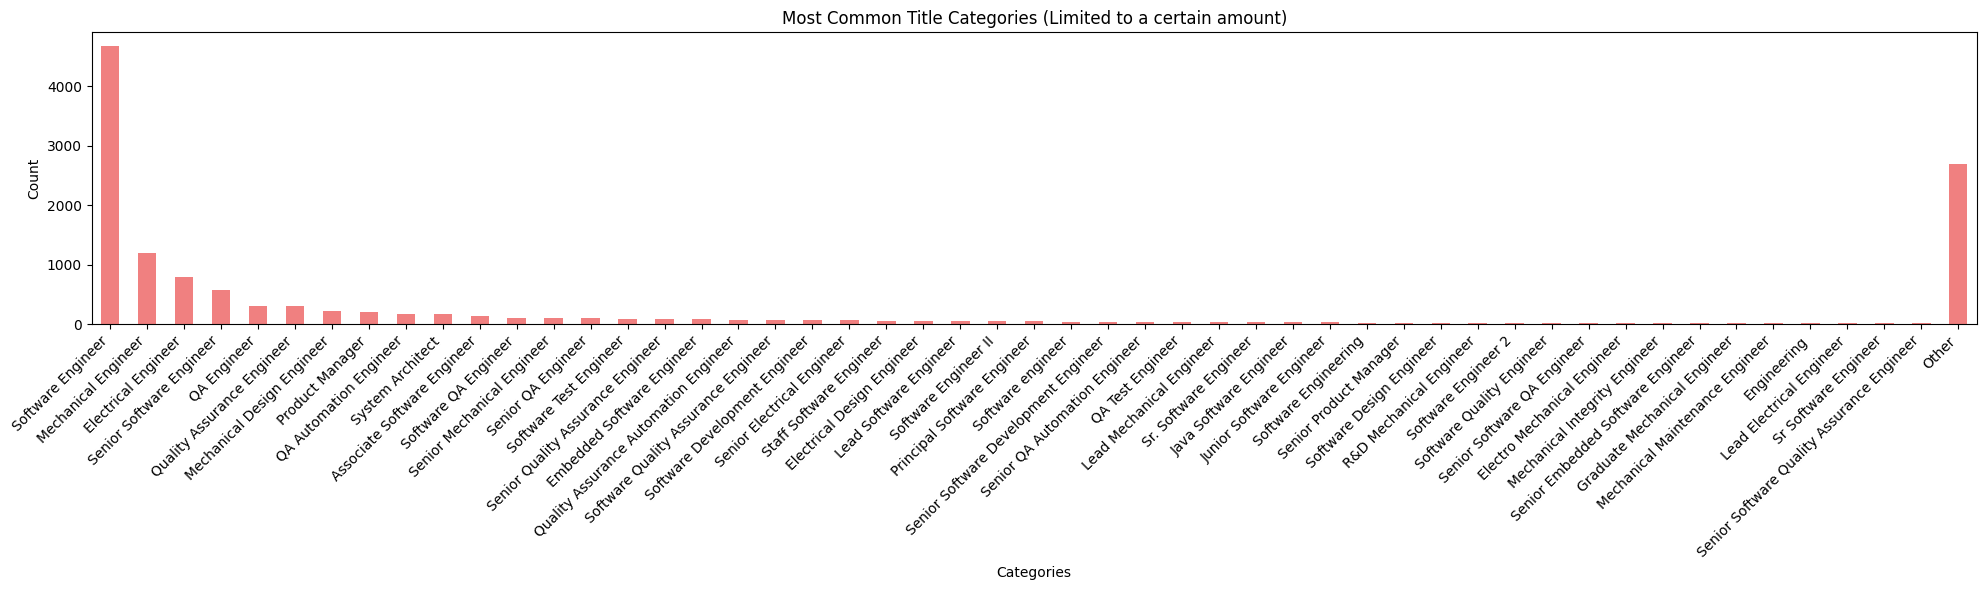

In [5]:
# @title GRAPH CATEGORIZED TITLES WITH GROUPING

import pandas as pd
import matplotlib.pyplot as plt

# Define the CSV file path in the shared folder
csv_file_path = "/content/drive/My Drive/VDC Engineering Contacts List/Test Engineer Contact List V1.csv"

# Check if the CSV file exists and read it into a DataFrame
if os.path.isfile(csv_file_path):
    df = pd.read_csv(csv_file_path)

    # Define a mapping of specific titles to broader categories
    title_mapping = {
        'software engineer': 'Software Engineering',
        'software engineer in test': 'Software Engineering',
        'qa engineer': 'Quality Assurance',
        'software qa engineer': 'Quality Assurance',
        'mechanical engineer': 'Engineering',
        'electrical engineer': 'Engineering',
        'product manager': 'Management',
        'system architect': 'Architecture',
        # Add more mappings as needed
    }

    # Replace titles with their categories
    df['Category'] = df['Title'].replace(title_mapping)

    # Count the occurrences of each category
    category_counts = df['Category'].value_counts()

    # Limit to top categories and group the rest as 'Other'
    if len(category_counts) > 50:
        top_categories = category_counts.nlargest(50).index
        category_counts = category_counts[category_counts.index.isin(top_categories)]

        # Count the 'Other' category
        other_count = df['Category'][~df['Category'].isin(top_categories)].count()
        category_counts = pd.concat([category_counts, pd.Series(other_count, index=['Other'])])

    # Plot the most common categories
    plt.figure(figsize=(20, 6))
    category_counts.plot(kind='bar', color='lightcoral')
    plt.title('Most Common Title Categories (Limited to a certain amount)')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print(f"File does not exist: {csv_file_path}")


In [ ]:
# @title Horizontal Copy & Paste Format [limited to 10 > GUESSED contacts---ORIGINAL CODE NO NEED TO TOUCH]
"""Right now for some reason, it's only allowing users to scrap "guessed" contacts, which is a little frustrating. Hopefully it can be udpated in the future"""


# API details
url = "https://api.apollo.io/v1/mixed_people/search"
api_key = 'ZuGNQ0UXawpNRxU_jxsbYQ'  # Your API key

# Define parameters for the search
data = {
    "q_organization_domains": "http://www.bp.com/",  # Target company domain
    "per_page": 100,  # Number of results per page
    "organization_num_employees_ranges": ["1,1000000"],  # Filter by company size range
    "person_titles": ["software engineer", "system architect", "software engineer in test", 'mechanical engineer', 'product manager', 'qa engineer', 'software qa engineer'],  # Search for titles
    #"contact_email_status": ["verified"],  # Filter for verified emails only

}

headers = {
    'Cache-Control': 'no-cache',
    'Content-Type': 'application/json',
    'X-Api-Key': api_key
}

# Number of pages to fetch
num_pages = 3

# Create a list to store each contact's title and email
contact_list = []

# Fetch data from the API
for page in range(1, num_pages + 1):
    # Update the page parameter
    data["page"] = page

    response = requests.post(url, headers=headers, json=data)

    if response.status_code == 200:
        result = response.json()
        people = result.get('people', [])

        if not people:
            print(f"No more results on page {page}.")
            break

        for person in people:
            email = person.get('email')
            # Filter out emails that are not unlocked
            if email and email != "email_not_unlocked@domain.com":
                title = person.get('title')
                contact_list.append([title, email])
                print(f"Name: {person.get('name')}")
                print(f"Title: {person.get('title')}")
                print(f"Email: {email}")
                print()

                # Stop after scraping data for 10 contacts (20 elements: 10 titles, 10 emails)
                if len(contact_list) >= 10:
                    break
        if len(contact_list) >= 10:
            break
    else:
        print(f"Error on page {page}: {response.status_code}, {response.text}")
        break

# Now create the MultiIndex DataFrame with blank columns in between contacts
columns = []
for i in range(1, len(contact_list) + 1):
    columns.extend([(f'Contact {i}', 'Title'), (f'Contact {i}', 'Email'), ('', '')])

# Remove the last blank column since it's not needed
columns = columns[:-1]

# Flatten the contact data into a list and insert NaN for blank columns
flattened_contacts = []
for contact in contact_list:
    flattened_contacts.extend(contact)
    flattened_contacts.append(np.nan)  # Add a blank space between contacts

# Remove the last blank entry
flattened_contacts = flattened_contacts[:-1]

# Create the DataFrame with the contacts and blank columns
df = pd.DataFrame([flattened_contacts], columns=pd.MultiIndex.from_tuples(columns))

# Display the DataFrame
df